# Required Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import pyswmm
from pyswmm import Simulation, LidControls, LidGroups, Subcatchments, Nodes
import os
import swmm
import swmmio as sio

# SUBBASIN DICTIONARIES (Dictionaries will be reference throughout the code)

In [2]:
#Subbasin LID Feasble Area Dictionaries
raingarden_feasible_areas = {'72591': 55583.9368, '72631': 19815.3296, '72671': 44162.83, '72731': 21000.83666, '72781': 23024.24035, '72951': 43306.46711, '73081': 13920.64411, '73121': 23892.97048, '73171': 0.0, '73181': 3385.30813, '73201': 9353.089577, '73211': 12806.63365, '73301': 636.1767258, '73321': 671.0354, '73391': 9520.57, '73421': 0.0, '73461': 5787.304599, '73531': 20854.943, '73551': 11511.16, '73571': 8611.12}
permeablepavement_feasible_areas = {'72591': 0.0, '72631': 3592.054222, '72671': 0.0, '72731': 9935.438827, '72781': 12553.53077, '72951': 14386.89196, '73081': 9687.51, '73121': 12827.45501, '73171': 9776.734992, '73181': 7534.73, '73201': 30138.92, '73211': 1076.39, '73301': 17222.24, '73321': 6647.736192, '73391': 1076.39, '73421': 7345.333808, '73461': 25833.36, '73531': 32600.9754, '73551': 0.0, '73571': 20832.98346}
greenroof_feasible_areas = {'72591': 2152.78, '72631': 12921.38023, '72671': 1173.503467, '72731': 29062.53, '72781': 7534.73, '72951': 9687.51, '73081': 21384.84111, '73121': 9357.285313, '73171': 16289.43527, '73181': 6990.681118, '73201': 30615.11554, '73211': 1296.256317, '73301': 16630.5235, '73321': 26148.32693, '73391': 0.0, '73421': 20630.7033, '73461': 71257.33823, '73531': 52908.96152, '73551': 10049.59107, '73571': 37450.83357}
bioretention_feasible_areas = {'72591': 1076.39, '72631': 1076.39, '72671': 1076.39, '72731': 3229.17, '72781': 7.996802699, '72951': 1068.393197, '73081': 0.0, '73121': 5381.95, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 1076.39, '73421': 0.0, '73461': 0.0, '73531': 1076.39, '73551': 0.0, '73571': 4305.56}
grassswale_feasible_areas = {'73081': 7534.73, '72671': 0.0, '72591': 2152.78, '72631': 3229.17, '72781': 0.0, '72731': 0.0, '72951': 10763.9, '73211': 0.0, '73181': 0.0, '73171': 0.0, '73121': 2152.78, '73201': 0.0, '73301': 0.0, '73321': 0.0, '73391': 10096.5382, '73461': 0.0, '73421': 0.0, '73551': 0.0, '73531': 0.0, '73571': 5177.4359}

#Other LID Dictionaries
raingarden_standard_surfaceareas = {'72591': 3212.817987, '72631': 4541.612969, '72671': 3645.423904, '72731': 3971.109854, '72781': 3623.50659, '72951': 2957.877903, '73081': 3989.072906, '73121': 4252.014151, '73171': 4757.523636, '73181': 5300.559781, '73201': 4880.873748, '73211': 3119.053128, '73301': 4951.325269, '73321': 5761.078663, '73391': 3528.284978, '73421': 5926.800739, '73461': 5934.625311, '73531': 5514.448276, '73551': 5515.048024, '73571': 5797.833294}
bioretention_standard_surfaceareas = {'72591': 3212.817987, '72631': 4541.612969, '72671': 3645.423904, '72731': 3971.109854, '72781': 3623.50659, '72951': 2957.877903, '73081': 3989.072906, '73121': 4252.014151, '73171': 4757.523636, '73181': 5300.559781, '73201': 4880.873748, '73211': 3119.053128, '73301': 4951.325269, '73321': 5761.078663, '73391': 3528.284978, '73421': 5926.800739, '73461': 5934.625311, '73531': 5514.448276, '73551': 5515.048024, '73571': 5797.833294}
grassswale_standard_surfaceareas = {'72591': 7460.877325, '72631': 10546.63456, '72671': 8465.4844, '72731': 9221.799549, '72781': 8414.587525, '72951': 6868.849797, '73081': 9263.513749, '73121': 9874.12175, '73171': 11048.02711, '73181': 12309.07771, '73201': 11334.47348, '73211': 7243.134487, '73301': 11498.07757, '73321': 13378.50489, '73391': 8193.461781, '73421': 13763.34838, '73461': 13781.51878, '73531': 12805.77433, '73551': 12807.16708, '73571': 13463.85732}


#Other Subbasin Characteristic Dictionaries
subbasin_areas = {'72591': 930398.04, '72631': 952047.36, '72671': 1011681.0, '72731': 954530.28, '72781': 1649965.68, '72951': 1785524.4, '73081': 1531569.6, '73121': 1481911.2, '73171': 677488.68, '73181': 626044.32, '73201': 922731.48, '73211': 1332718.2, '73301': 1379980.8, '73321': 629311.32, '73391': 762430.68, '73421': 672827.76, '73461': 708067.8, '73531': 677662.92, '73551': 603218.88, '73571': 368648.28}
subbasin_imperv_areas = {'72591': 230720.106, '72631': 418386.7328, '72671': 294287.8861, '72731': 506340.1323, '72781': 530480.4658, '72951': 419348.2606, '73081': 545667.6171, '73121': 717393.2119, '73171': 390782.2455, '73181': 431162.9836, '73201': 494805.5288, '73211': 431094.3562, '73301': 632569.3989, '73321': 437044.1255, '73391': 164067.458, '73421': 504230.5799, '73461': 532764.3741, '73531': 469972.7883, '73551': 412975.7096, '73571': 253029.1199}
subbasin_perv_areas = {'72591': 699677.934, '72631': 533660.6272, '72671': 717393.1139, '72731': 448190.1477, '72781': 1119485.214, '72951': 1366176.139, '73081': 985901.9829, '73121': 764517.9881, '73171': 286706.4345, '73181': 194881.3364, '73201': 427925.9512, '73211': 901623.8438, '73301': 747411.4011, '73321': 192267.1945, '73391': 598363.222, '73421': 168597.1801, '73461': 175303.4259, '73531': 207690.1317, '73551': 190243.1704, '73571': 115619.1601}
subbasin_flowlengths = {'72591': 1094.586, '72631': 793.373, '72671': 1445.259, '72731': 1272.707, '72781': 1833.295, '72951': 915.654, '73081': 957.231, '73121': 4234.032, '73171': 615.899, '73181': 2086.814, '73201': 1419.587, '73211': 1665.898, '73301': 2759.962, '73321': 968.171, '73391': 476.519, '73421': 480.591, '73461': 708.068, '73531': 1042.558, '73551': 928.029, '73571': 1053.281}


# LID Area Scenario Generator. Can only run one of these. Must Comment out the option that isnt being used!

## Option 1: Manually Change in Block Below

In [3]:
# raingarden_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# permeablepavement_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# greenroof_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# bioretention_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}
# grassswale_assigned_areas = {'72591': None, '72631': None, '72671': None, '72731': None, '72781': None, '72951': None, '73081': None, '73121': None, '73171': None, '73181': None, '73201': None, '73211': None, '73301': None, '73321': None, '73391': None, '73421': None, '73461': None, '73531': None, '73551': None, '73571': None}

## Option 2: Random LID Area allocation

In [4]:
#Generating random area allocation scenarios for each subcatchment. 
### Random LID scenario generator.  

allocations_fractions_list = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

for key in raingarden_feasible_areas:
    raingarden_assigned_areas = raingarden_feasible_areas
    raingarden_assigned_areas[key] *= random.choice(allocations_fractions_list)
            

for key in greenroof_feasible_areas:
    greenroof_assigned_areas = greenroof_feasible_areas
    greenroof_assigned_areas[key] *= random.choice(allocations_fractions_list)
    
    
for key in permeablepavement_feasible_areas:
    permeablepavement_assigned_areas = permeablepavement_feasible_areas
    permeablepavement_assigned_areas[key] *= random.choice(allocations_fractions_list)
    

for key in bioretention_feasible_areas:
    bioretention_assigned_areas = bioretention_feasible_areas
    bioretention_assigned_areas[key] *= random.choice(allocations_fractions_list)
    
    
for key in grassswale_feasible_areas:
    grassswale_assigned_areas = grassswale_feasible_areas
    grassswale_assigned_areas[key] *= random.choice(allocations_fractions_list)



# Calculate total implemented LID areas for each subbasin

In [5]:
subbasinlist = ['72591', '72631', '72671', '72731', '72781', '72951', '73081','73121','73171','73181', '73201', '73211', '73301', '73321', '73391', '73421', '73461', '73531', '73551','73571']
lid_total_areas = dict.fromkeys(subbasinlist)

for key in lid_total_areas:
    lid_total_areas[key] = greenroof_assigned_areas[key] + permeablepavement_assigned_areas[key] + raingarden_assigned_areas[key] + bioretention_assigned_areas[key] + grassswale_assigned_areas[key]

print(lid_total_areas)

{'72591': 46727.56844000001, '72631': 19678.526389, '72671': 14911.990733499999, '72731': 27510.7456103, '72781': 29223.393107159198, '72951': 43629.6896478, '73081': 35219.38469800001, '73121': 31200.339465000005, '73171': 9122.3911342, '73181': 7416.0152216, '73201': 27787.2653659, '73211': 8257.4606152, '73301': 27773.11315322, '73321': 11855.981550400002, '73391': 14999.395100000002, '73421': 9721.348081600001, '73461': 34695.285202700004, '73531': 49555.907867999995, '73551': 15805.17107, '73571': 59814.339059000005}


### Update impervious LID areas for each subbasin after LID implementation
### This block appears periodically to reset the updated subbasin impervious area dictionary

In [6]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


# Permeable Pavement LID Usage Editor Parameter Changes!
## Permeable Pavement Percent Impervious Treated Calculation for each Subbasin

In [7]:
permeablepavement_percimpervtreated = subbasindict

for key in permeablepavement_percimpervtreated:
    permeablepavement_percimpervtreated[key] = ((permeablepavement_assigned_areas[key] * 2.5) / updated_sb_impervious_areas[key])*100
print(permeablepavement_percimpervtreated)    

{'72591': 0.0, '72631': 2.2274071001305575, '72671': 0.0, '72731': 4.62958509083586, '72781': 3.0195172089336673, '72951': 1.7558282019828737, '73081': 0.9235281217358948, '73121': 3.676679182063264, '73171': 0.6404089191045449, '73181': 0.8869343363855322, '73201': 6.364256834749868, '73211': 0.6269158671999955, '73301': 7.11229201334677, '73321': 0.7816171853543767, '73391': 0.3284637409157449, '73421': 0.7426892498032724, '73461': 12.92171222445006, '73531': 7.481254827706022, '73551': 0.0, '73571': 15.109242016202867}


# RainGarden LID Usage Editor Parameter Changes!

## Percent of Impervious Area Treated Calculations for each Subbasin

In [8]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [9]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (raingarden_assigned_areas[key] / raingarden_standard_surfaceareas[key])
print(totalunits)

{'72591': 13.840544226260898, '72631': 0.4363059938232267, '72671': 3.634378154338234, '72731': 0.528840486214361, '72781': 5.083305859256075, '72951': 10.248741824756786, '73081': 3.1407246731829974, '73121': 1.685763708550743, '73171': 0.0, '73181': 0.19160097819109945, '73201': 1.3413915298634356, '73211': 2.0529681804765976, '73301': 0.115637535834045, '73321': 0.011647738891497235, '73391': 2.698356300401991, '73421': 0.0, '73461': 0.2925528215710466, '73531': 2.6473110943003064, '73551': 1.0436137591102144, '73571': 1.3367076297313079}


In [10]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 21780
print(totaldrainageareatreated)

{'72591': 301447.0532479623, '72631': 9502.744545469877, '72671': 79156.75620148674, '72731': 11518.145789748782, '72781': 110714.40161459731, '72951': 223217.5969432028, '73081': 68404.98338192569, '73121': 36715.93357223518, '73171': 0.0, '73181': 4173.069305002146, '73201': 29215.507520425628, '73211': 44713.6469707803, '73301': 2518.5855304655, '73321': 253.68775305680978, '73391': 58770.20022275536, '73421': 0.0, '73461': 6371.8004538173955, '73531': 57658.435633860674, '73551': 22729.90767342047, '73571': 29113.492175547886}


In [11]:
raingarden_impervareatreated = subbasindict

for key in raingarden_impervareatreated:
    quarter = 0.25
    raingarden_impervareatreated[key] = totaldrainageareatreated[key] * quarter
print(raingarden_impervareatreated)

{'72591': 75361.76331199058, '72631': 2375.6861363674693, '72671': 19789.189050371686, '72731': 2879.5364474371954, '72781': 27678.60040364933, '72951': 55804.3992358007, '73081': 17101.245845481422, '73121': 9178.983393058796, '73171': 0.0, '73181': 1043.2673262505366, '73201': 7303.876880106407, '73211': 11178.411742695074, '73301': 629.646382616375, '73321': 63.421938264202446, '73391': 14692.55005568884, '73421': 0.0, '73461': 1592.9501134543489, '73531': 14414.608908465168, '73551': 5682.476918355117, '73571': 7278.373043886972}


In [12]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [13]:
raingarden_percimpervareatreated = subbasindict

for key in raingarden_percimpervareatreated:
    raingarden_percimpervareatreated[key] = (raingarden_impervareatreated[key]/updated_sb_impervious_areas[key])*100
print(raingarden_percimpervareatreated)

{'72591': 32.75540661582125, '72631': 0.5892583842880124, '72671': 6.737866060019164, '72731': 0.5963415624367882, '72781': 5.3260560248273485, '72951': 13.621140444420268, '73081': 3.26058635397976, '73121': 1.3154665959636718, '73171': 0.0, '73181': 0.24561188355275593, '73201': 1.5423163256808385, '73211': 2.6042321803771107, '73301': 0.10401037120177463, '73321': 0.014913852007376695, '73391': 8.966954272862795, '73421': 0.0, '73461': 0.31871414254997676, '73531': 3.3078569325858043, '73551': 1.410302449264536, '73571': 3.5191214935822863}


In [14]:
for key in raingarden_percimpervareatreated:
    if raingarden_percimpervareatreated[key] > 100:
        raingarden_percimpervareatreated[key] = 100
print(raingarden_percimpervareatreated)

{'72591': 32.75540661582125, '72631': 0.5892583842880124, '72671': 6.737866060019164, '72731': 0.5963415624367882, '72781': 5.3260560248273485, '72951': 13.621140444420268, '73081': 3.26058635397976, '73121': 1.3154665959636718, '73171': 0.0, '73181': 0.24561188355275593, '73201': 1.5423163256808385, '73211': 2.6042321803771107, '73301': 0.10401037120177463, '73321': 0.014913852007376695, '73391': 8.966954272862795, '73421': 0.0, '73461': 0.31871414254997676, '73531': 3.3078569325858043, '73551': 1.410302449264536, '73571': 3.5191214935822863}


## Calculations for RainGarden Percent Pervious Area Treated for each Subbasin

In [15]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [16]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (raingarden_assigned_areas[key] / raingarden_standard_surfaceareas[key])
print(totalunits)

{'72591': 13.840544226260898, '72631': 0.4363059938232267, '72671': 3.634378154338234, '72731': 0.528840486214361, '72781': 5.083305859256075, '72951': 10.248741824756786, '73081': 3.1407246731829974, '73121': 1.685763708550743, '73171': 0.0, '73181': 0.19160097819109945, '73201': 1.3413915298634356, '73211': 2.0529681804765976, '73301': 0.115637535834045, '73321': 0.011647738891497235, '73391': 2.698356300401991, '73421': 0.0, '73461': 0.2925528215710466, '73531': 2.6473110943003064, '73551': 1.0436137591102144, '73571': 1.3367076297313079}


In [17]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 21780
print(totaldrainageareatreated)

{'72591': 301447.0532479623, '72631': 9502.744545469877, '72671': 79156.75620148674, '72731': 11518.145789748782, '72781': 110714.40161459731, '72951': 223217.5969432028, '73081': 68404.98338192569, '73121': 36715.93357223518, '73171': 0.0, '73181': 4173.069305002146, '73201': 29215.507520425628, '73211': 44713.6469707803, '73301': 2518.5855304655, '73321': 253.68775305680978, '73391': 58770.20022275536, '73421': 0.0, '73461': 6371.8004538173955, '73531': 57658.435633860674, '73551': 22729.90767342047, '73571': 29113.492175547886}


In [18]:
raingarden_pervareatreated = subbasindict

for key in raingarden_pervareatreated:
    threequarter = 0.75
    raingarden_pervareatreated[key] = totaldrainageareatreated[key] * threequarter
print(raingarden_pervareatreated)

{'72591': 226085.28993597173, '72631': 7127.058409102408, '72671': 59367.56715111506, '72731': 8638.609342311585, '72781': 83035.80121094799, '72951': 167413.1977074021, '73081': 51303.73753644427, '73121': 27536.950179176387, '73171': 0.0, '73181': 3129.8019787516096, '73201': 21911.63064031922, '73211': 33535.23522808522, '73301': 1888.9391478491252, '73321': 190.26581479260733, '73391': 44077.65016706652, '73421': 0.0, '73461': 4778.850340363047, '73531': 43243.826725395505, '73551': 17047.43075506535, '73571': 21835.119131660915}


In [19]:
raingarden_percpervareatreated = subbasindict

for key in raingarden_percimpervareatreated:
    raingarden_percpervareatreated[key] = (raingarden_pervareatreated[key]/subbasin_perv_areas[key])*100
print(raingarden_percpervareatreated)

{'72591': 32.31276548103513, '72631': 1.3355038850245553, '72671': 8.275458183362282, '72731': 1.9274429361383274, '72781': 7.417320047868715, '72951': 12.254144464120385, '73081': 5.203736114368684, '73121': 3.6018708006612026, '73171': 0.0, '73181': 1.6060039594184605, '73201': 5.1204257603153325, '73211': 3.7194263947975266, '73301': 0.2527308447622134, '73321': 0.09895906334276246, '73391': 7.366370215692589, '73421': 0.0, '73461': 2.7260450363868483, '73531': 20.82131990164052, '73551': 8.960863467120474, '73571': 18.88538120565444}


In [20]:
for key in raingarden_percpervareatreated:
    if raingarden_percpervareatreated[key] > 100:
        raingarden_percpervareatreated[key] = 100
print(raingarden_percpervareatreated)

{'72591': 32.31276548103513, '72631': 1.3355038850245553, '72671': 8.275458183362282, '72731': 1.9274429361383274, '72781': 7.417320047868715, '72951': 12.254144464120385, '73081': 5.203736114368684, '73121': 3.6018708006612026, '73171': 0.0, '73181': 1.6060039594184605, '73201': 5.1204257603153325, '73211': 3.7194263947975266, '73301': 0.2527308447622134, '73321': 0.09895906334276246, '73391': 7.366370215692589, '73421': 0.0, '73461': 2.7260450363868483, '73531': 20.82131990164052, '73551': 8.960863467120474, '73571': 18.88538120565444}


# Bioretention LID Usage Editor Parameter Changes!

## Percent of Impervious Area Treated Calculations for each Subbasin

In [21]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [22]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (bioretention_assigned_areas[key] / bioretention_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.30152688509584097, '72631': 0.04740122099118482, '72671': 0.2952715591783205, '72731': 0.4878993710154864, '72781': 0.0017655389883532682, '72951': 0.14448104107561605, '73081': 0.0, '73121': 0.6328706595125345, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.06101491272454694, '73421': 0.0, '73461': 0.0, '73531': 0.13663615329919182, '73551': 0.0, '73571': 0.7426153498507265}


In [23]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 49254.41668040562, '72631': 7742.989448910041, '72671': 48232.609191778654, '72731': 79698.3622553797, '72781': 288.4007937475064, '72951': 23600.97805970188, '73081': 0.0, '73121': 103379.42223137252, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 9966.785993554742, '73421': 0.0, '73461': 0.0, '73531': 22319.515641422982, '73551': 0.0, '73571': 121306.21739811618}


In [24]:
bioretention_impervareatreated = subbasindict

for key in bioretention_impervareatreated:
    bioretention_impervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(bioretention_impervareatreated)

{'72591': 24627.20834020281, '72631': 3871.4947244550203, '72671': 24116.304595889327, '72731': 39849.18112768985, '72781': 144.2003968737532, '72951': 11800.48902985094, '73081': 0.0, '73121': 51689.71111568626, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 4983.392996777371, '73421': 0.0, '73461': 0.0, '73531': 11159.757820711491, '73551': 0.0, '73571': 60653.10869905809}


In [25]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [26]:
bioretention_percimpervareatreated = subbasindict

for key in bioretention_percimpervareatreated:
    bioretention_percimpervareatreated[key] = (bioretention_impervareatreated[key]/updated_sb_impervious_areas[key])*100
print(bioretention_percimpervareatreated)

{'72591': 10.704025324571194, '72631': 0.9602744618445918, '72671': 8.211171757271929, '72731': 8.252620992751453, '72781': 0.027747768360812317, '72951': 2.8803485135509144, '73081': 0.0, '73121': 7.407801650356665, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 3.0413956022906565, '73421': 0.0, '73461': 0.0, '73531': 2.5609354029397497, '73551': 0.0, '73571': 29.326012446519044}


In [27]:
for key in bioretention_percimpervareatreated:
    if bioretention_percimpervareatreated[key] > 100:
        bioretention_percimpervareatreated[key] = 100
print(bioretention_percimpervareatreated)

{'72591': 10.704025324571194, '72631': 0.9602744618445918, '72671': 8.211171757271929, '72731': 8.252620992751453, '72781': 0.027747768360812317, '72951': 2.8803485135509144, '73081': 0.0, '73121': 7.407801650356665, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 3.0413956022906565, '73421': 0.0, '73461': 0.0, '73531': 2.5609354029397497, '73551': 0.0, '73571': 29.326012446519044}


## Bioretention Percent Pervious Area Treated for each Subbasin

In [28]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [29]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (bioretention_assigned_areas[key] / bioretention_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.30152688509584097, '72631': 0.04740122099118482, '72671': 0.2952715591783205, '72731': 0.4878993710154864, '72781': 0.0017655389883532682, '72951': 0.14448104107561605, '73081': 0.0, '73121': 0.6328706595125345, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.06101491272454694, '73421': 0.0, '73461': 0.0, '73531': 0.13663615329919182, '73551': 0.0, '73571': 0.7426153498507265}


In [30]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 49254.41668040562, '72631': 7742.989448910041, '72671': 48232.609191778654, '72731': 79698.3622553797, '72781': 288.4007937475064, '72951': 23600.97805970188, '73081': 0.0, '73121': 103379.42223137252, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 9966.785993554742, '73421': 0.0, '73461': 0.0, '73531': 22319.515641422982, '73551': 0.0, '73571': 121306.21739811618}


In [31]:
bioretention_pervareatreated = subbasindict

for key in bioretention_pervareatreated:
    bioretention_pervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(bioretention_pervareatreated)

{'72591': 24627.20834020281, '72631': 3871.4947244550203, '72671': 24116.304595889327, '72731': 39849.18112768985, '72781': 144.2003968737532, '72951': 11800.48902985094, '73081': 0.0, '73121': 51689.71111568626, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 4983.392996777371, '73421': 0.0, '73461': 0.0, '73531': 11159.757820711491, '73551': 0.0, '73571': 60653.10869905809}


In [32]:
bioretention_percpervareatreated = subbasindict

for key in bioretention_percpervareatreated:
    bioretention_percpervareatreated[key] = (bioretention_pervareatreated[key]/subbasin_perv_areas[key])*100
print(bioretention_percpervareatreated)

{'72591': 3.519792056240952, '72631': 0.7254600634054459, '72671': 3.361658221778107, '72731': 8.891132777502119, '72781': 0.01288095591352341, '72951': 0.8637604400329041, '73081': 0.0, '73121': 6.7610850130743, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.8328374494877246, '73421': 0.0, '73461': 0.0, '73531': 5.373273024272193, '73551': 0.0, '73571': 52.459392237928995}


In [33]:
for key in bioretention_percpervareatreated:
    if bioretention_percpervareatreated[key] > 100:
        bioretention_percpervareatreated[key] = 100
print(bioretention_percpervareatreated)

{'72591': 3.519792056240952, '72631': 0.7254600634054459, '72671': 3.361658221778107, '72731': 8.891132777502119, '72781': 0.01288095591352341, '72951': 0.8637604400329041, '73081': 0.0, '73121': 6.7610850130743, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.8328374494877246, '73421': 0.0, '73461': 0.0, '73531': 5.373273024272193, '73551': 0.0, '73571': 52.459392237928995}


# Grass Swale LID Usage Editor Parameter Changes!

## Percent of Impervious Area Treated Calculations for each Subbasin

In [34]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [35]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (grassswale_assigned_areas[key] / grassswale_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.08656274213703145, '72631': 0.21432609493961643, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 0.47011801035602113, '73081': 0.16267542110170402, '73121': 0.1744179425375224, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.6161338436589212, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 0.11536298499633835}


In [36]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 14140.023928084089, '72631': 35010.16760838634, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 76793.77699165605, '73081': 26573.03003696335, '73121': 28491.170913504284, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 100645.46336168479, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 18844.543599151868}


In [37]:
grassswale_impervareatreated = subbasindict

for key in grassswale_impervareatreated:
    grassswale_impervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(grassswale_impervareatreated)

{'72591': 7070.011964042044, '72631': 17505.08380419317, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 38396.888495828025, '73081': 13286.515018481676, '73121': 14245.585456752142, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 50322.73168084239, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 9422.271799575934}


In [38]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [39]:
grassswale_percimpervareatreated = subbasindict

for key in grassswale_percimpervareatreated:
    grassswale_percimpervareatreated[key] = (grassswale_impervareatreated[key]/updated_sb_impervious_areas[key])*100
print(grassswale_percimpervareatreated)

{'72591': 3.072925930649927, '72631': 4.3419108447790355, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 9.372189612156733, '73081': 2.533255761167553, '73121': 2.041575957363026, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 30.71227473497294, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 4.555704826933963}


In [40]:
for key in grassswale_percimpervareatreated:
    if grassswale_percimpervareatreated[key] > 100:
        grassswale_percimpervareatreated[key] = 100
print(grassswale_percimpervareatreated)

{'72591': 3.072925930649927, '72631': 4.3419108447790355, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 9.372189612156733, '73081': 2.533255761167553, '73121': 2.041575957363026, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 30.71227473497294, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 4.555704826933963}


## Percent of pervious Area Treated Calculations for each Subbasin

In [41]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [42]:
totalunits = subbasindict

for key in totalunits:
    totalunits[key] = (grassswale_assigned_areas[key] / grassswale_standard_surfaceareas[key])
print(totalunits)

{'72591': 0.08656274213703145, '72631': 0.21432609493961643, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 0.47011801035602113, '73081': 0.16267542110170402, '73121': 0.1744179425375224, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 0.6161338436589212, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 0.11536298499633835}


In [43]:
totaldrainageareatreated = subbasindict

for key in totaldrainageareatreated:
    totaldrainageareatreated[key] = totalunits[key] * 163350
print(totaldrainageareatreated)

{'72591': 14140.023928084089, '72631': 35010.16760838634, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 76793.77699165605, '73081': 26573.03003696335, '73121': 28491.170913504284, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 100645.46336168479, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 18844.543599151868}


In [44]:
grassswale_pervareatreated = subbasindict

for key in grassswale_pervareatreated:
    grassswale_pervareatreated[key] = totaldrainageareatreated[key] * 0.5
print(grassswale_pervareatreated)

{'72591': 7070.011964042044, '72631': 17505.08380419317, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 38396.888495828025, '73081': 13286.515018481676, '73121': 14245.585456752142, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 50322.73168084239, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 9422.271799575934}


In [45]:
grassswale_percpervareatreated = subbasindict

for key in grassswale_percpervareatreated:
    grassswale_percpervareatreated[key] = (grassswale_pervareatreated[key]/subbasin_perv_areas[key])*100
print(grassswale_percpervareatreated)

{'72591': 1.0104666190662008, '72631': 3.2801902392609508, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 2.8105371920734465, '73081': 1.3476507045253936, '73121': 1.863342089851364, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 8.410064293831615, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 8.149403430561621}


In [46]:
for key in grassswale_percimpervareatreated:
    if grassswale_percimpervareatreated[key] > 100:
        grassswale_percimpervareatreated[key] = 100
print(grassswale_percpervareatreated)

{'72591': 1.0104666190662008, '72631': 3.2801902392609508, '72671': 0.0, '72731': 0.0, '72781': 0.0, '72951': 2.8105371920734465, '73081': 1.3476507045253936, '73121': 1.863342089851364, '73171': 0.0, '73181': 0.0, '73201': 0.0, '73211': 0.0, '73301': 0.0, '73321': 0.0, '73391': 8.410064293831615, '73421': 0.0, '73461': 0.0, '73531': 0.0, '73551': 0.0, '73571': 8.149403430561621}


## Capping total %impervious and %pervious at 100% for each subcatchment-LID combo. 

In [47]:
subbasinlist = ['72591', '72631', '72671', '72731', '72781', '72951', '73081','73121','73171','73181', '73201', '73211', '73301', '73321', '73391', '73421', '73461', '73531', '73551','73571']
percimptreated_sbs = dict.fromkeys(subbasinlist)

for key in percimptreated_sbs:
    percimptreated_sbs[key] = raingarden_percimpervareatreated[key] + bioretention_percimpervareatreated[key] + permeablepavement_percimpervtreated[key] + grassswale_percimpervareatreated[key]
print(percimptreated_sbs)  

{'72591': 46.53235787104238, '72631': 8.118850791042197, '72671': 14.949037817291092, '72731': 13.4785476460241, '72781': 8.373321002121827, '72951': 27.629506772110787, '73081': 6.717370236883207, '73121': 14.441523385746626, '73171': 0.6404089191045449, '73181': 1.132546219938288, '73201': 7.906573160430706, '73211': 3.231148047577106, '73301': 7.216302384548545, '73321': 0.7965310373617535, '73391': 43.04908835104214, '73421': 0.7426892498032724, '73461': 13.240426367000037, '73531': 13.350047163231576, '73551': 1.410302449264536, '73571': 52.510080783238166}


In [48]:
while percimptreated_sbs['72671'] > 100:
    raingarden_percimpervareatreated['72671'] =  raingarden_percimpervareatreated['72671']-0.25
    for key in percimptreated_sbs:
        percimptreated_sbs[key] = raingarden_percimpervareatreated[key] + bioretention_percimpervareatreated[key] + permeablepavement_percimpervtreated[key] + grassswale_percimpervareatreated[key]
        
print(percimptreated_sbs)


{'72591': 46.53235787104238, '72631': 8.118850791042197, '72671': 14.949037817291092, '72731': 13.4785476460241, '72781': 8.373321002121827, '72951': 27.629506772110787, '73081': 6.717370236883207, '73121': 14.441523385746626, '73171': 0.6404089191045449, '73181': 1.132546219938288, '73201': 7.906573160430706, '73211': 3.231148047577106, '73301': 7.216302384548545, '73321': 0.7965310373617535, '73391': 43.04908835104214, '73421': 0.7426892498032724, '73461': 13.240426367000037, '73531': 13.350047163231576, '73551': 1.410302449264536, '73571': 52.510080783238166}


In [49]:
subbasinlist = ['72591', '72631', '72671', '72731', '72781', '72951', '73081','73121','73171','73181', '73201', '73211', '73301', '73321', '73391', '73421', '73461', '73531', '73551','73571']
percpervtreated_sbs = dict.fromkeys(subbasinlist)

for key in percpervtreated_sbs:
    percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key]
print(percpervtreated_sbs)  

{'72591': 36.84302415634228, '72631': 5.341154187690952, '72671': 11.63711640514039, '72731': 10.818575713640445, '72781': 7.430201003782239, '72951': 15.928442096226735, '73081': 6.551386818894078, '73121': 12.226297903586868, '73171': 0.0, '73181': 1.6060039594184605, '73201': 5.1204257603153325, '73211': 3.7194263947975266, '73301': 0.2527308447622134, '73321': 0.09895906334276246, '73391': 16.609271959011927, '73421': 0.0, '73461': 2.7260450363868483, '73531': 26.194592925912715, '73551': 8.960863467120474, '73571': 79.49417687414505}


In [50]:
while percpervtreated_sbs['73571'] > 100:
    raingarden_percpervareatreated['73571'] =  raingarden_percpervareatreated['73571']-0.25
    for key in percpervtreated_sbs:
        percpervtreated_sbs[key] = raingarden_percpervareatreated[key] + bioretention_percpervareatreated[key] + grassswale_percpervareatreated[key] 
    


# The following blocks update subcatchment percent impervious and widths using SWMMIO 

In [51]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_impervious_areas = subbasindict

for key in updated_sb_impervious_areas:
    updated_sb_impervious_areas[key] = subbasin_imperv_areas[key] - greenroof_assigned_areas[key] - permeablepavement_assigned_areas[key]
print(updated_sb_impervious_areas)

{'72591': 230074.272, '72631': 403165.436371, '72671': 293701.1343665, '72731': 482866.9723557, '72781': 519682.86241500004, '72951': 409689.625208, '73081': 524483.7581010001, '73121': 697773.962579, '73171': 381659.8543658, '73181': 424762.5608174, '73201': 473565.426138, '73211': 429240.2124098, '73301': 605368.8448000001, '73321': 425255.24748960003, '73391': 163852.18000000002, '73421': 494509.2318184, '73461': 499805.28027700004, '73531': 435768.813532, '73551': 402926.11853, '73571': 206823.579611}


In [52]:
print(subbasin_areas)

{'72591': 930398.04, '72631': 952047.36, '72671': 1011681.0, '72731': 954530.28, '72781': 1649965.68, '72951': 1785524.4, '73081': 1531569.6, '73121': 1481911.2, '73171': 677488.68, '73181': 626044.32, '73201': 922731.48, '73211': 1332718.2, '73301': 1379980.8, '73321': 629311.32, '73391': 762430.68, '73421': 672827.76, '73461': 708067.8, '73531': 677662.92, '73551': 603218.88, '73571': 368648.28}


In [53]:
subbasindict = dict.fromkeys(subbasinlist)
updated_sb_percent_impervious_areas = subbasindict
for key in updated_sb_percent_impervious_areas:
    updated_sb_percent_impervious_areas[key] = (updated_sb_impervious_areas[key] / subbasin_areas[key])*100
print(updated_sb_percent_impervious_areas)

{'72591': 24.728585197793407, '72631': 42.34720385874501, '72671': 29.03100229879775, '72731': 50.58686795726375, '72781': 31.496586184447185, '72951': 22.94505889743092, '73081': 34.24485299923686, '73121': 47.08608468435896, '73171': 56.334499104221194, '73181': 67.84864062298337, '73201': 51.32212744470364, '73211': 32.207875033881884, '73301': 43.86791793045237, '73321': 67.57470173738494, '73391': 21.490764248888834, '73421': 73.49715056620137, '73461': 70.58720651850007, '73531': 64.30465658826367, '73551': 66.79600587600972, '73571': 56.10322652556523}


In [54]:
#initialize a baseline model object in swmmio
baseline = sio.Model(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\MeadowCreekSWMM')

#isolate subcatchments dataframe
subcatchments = baseline.inp.subcatchments

#Set subcatchment parameters

#Percent Impervious Adjustments

subcatchments.loc['73081','PercImperv'] = updated_sb_impervious_areas['73081']
subcatchments.loc['72671','PercImperv'] = updated_sb_impervious_areas['72671']
subcatchments.loc['72591','PercImperv'] = updated_sb_impervious_areas['72591']
subcatchments.loc['72631','PercImperv'] = updated_sb_impervious_areas['72631']
subcatchments.loc['72781','PercImperv'] = updated_sb_impervious_areas['72781']
subcatchments.loc['72731','PercImperv'] = updated_sb_impervious_areas['72731']
subcatchments.loc['72951','PercImperv'] = updated_sb_impervious_areas['72951']
subcatchments.loc['73211','PercImperv'] = updated_sb_impervious_areas['73211']
subcatchments.loc['73181','PercImperv'] = updated_sb_impervious_areas['73181']
subcatchments.loc['73171','PercImperv'] = updated_sb_impervious_areas['73171']
subcatchments.loc['73121','PercImperv'] = updated_sb_impervious_areas['73121']
subcatchments.loc['73201','PercImperv'] = updated_sb_impervious_areas['73201']
subcatchments.loc['73301','PercImperv'] = updated_sb_impervious_areas['73301']
subcatchments.loc['73321','PercImperv'] = updated_sb_impervious_areas['73321']
subcatchments.loc['73391','PercImperv'] = updated_sb_impervious_areas['73391']
subcatchments.loc['73461','PercImperv'] = updated_sb_impervious_areas['73461']
subcatchments.loc['73551','PercImperv'] = updated_sb_impervious_areas['73551']
subcatchments.loc['73421','PercImperv'] = updated_sb_impervious_areas['73421']
subcatchments.loc['73531','PercImperv'] = updated_sb_impervious_areas['73531']
subcatchments.loc['73571','PercImperv'] = updated_sb_impervious_areas['73571']

#Width Adjustment((SUBBASIN AREA/Flow Length) - LID Width)

subcatchments.loc['73081','Width'] = ((subcatchments.loc['73081','Area'] * 43560)/subbasin_flowlengths['73081']) - (lid_total_areas['73081']/subbasin_flowlengths['73081'])
subcatchments.loc['72671','Width'] = ((subcatchments.loc['72671','Area'] * 43560)/subbasin_flowlengths['72671']) - (lid_total_areas['73461']/subbasin_flowlengths['72671'])
subcatchments.loc['72591','Width'] = ((subcatchments.loc['72591','Area'] * 43560)/subbasin_flowlengths['72591']) - (lid_total_areas['72591']/subbasin_flowlengths['72591'])
subcatchments.loc['72631','Width'] = ((subcatchments.loc['72631','Area'] * 43560)/subbasin_flowlengths['72631']) - (lid_total_areas['72631']/subbasin_flowlengths['72631'])
subcatchments.loc['72781','Width'] = ((subcatchments.loc['72781','Area'] * 43560)/subbasin_flowlengths['72781']) - (lid_total_areas['72781']/subbasin_flowlengths['72781'])
subcatchments.loc['72731','Width'] = ((subcatchments.loc['72731','Area'] * 43560)/subbasin_flowlengths['72731']) - (lid_total_areas['72731']/subbasin_flowlengths['72731'])
subcatchments.loc['72951','Width'] = ((subcatchments.loc['72951','Area'] * 43560)/subbasin_flowlengths['72951']) - (lid_total_areas['72951']/subbasin_flowlengths['72951'])
subcatchments.loc['73211','Width'] = ((subcatchments.loc['73211','Area'] * 43560)/subbasin_flowlengths['73211']) - (lid_total_areas['73211']/subbasin_flowlengths['73211'])
subcatchments.loc['73181','Width'] = ((subcatchments.loc['73181','Area'] * 43560)/subbasin_flowlengths['73181']) - (lid_total_areas['73181']/subbasin_flowlengths['73181'])
subcatchments.loc['73171','Width'] = ((subcatchments.loc['73171','Area'] * 43560)/subbasin_flowlengths['73171']) - (lid_total_areas['73171']/subbasin_flowlengths['73171'])
subcatchments.loc['73121','Width'] = ((subcatchments.loc['73121','Area'] * 43560)/subbasin_flowlengths['73121']) - (lid_total_areas['73121']/subbasin_flowlengths['73121'])
subcatchments.loc['73201','Width'] = ((subcatchments.loc['73201','Area'] * 43560)/subbasin_flowlengths['73201']) - (lid_total_areas['73201']/subbasin_flowlengths['73201'])
subcatchments.loc['73301','Width'] = ((subcatchments.loc['73301','Area'] * 43560)/subbasin_flowlengths['73301']) - (lid_total_areas['73301']/subbasin_flowlengths['73301'])
subcatchments.loc['73321','Width'] = ((subcatchments.loc['73321','Area'] * 43560)/subbasin_flowlengths['73321']) - (lid_total_areas['73321']/subbasin_flowlengths['73321'])
subcatchments.loc['73391','Width'] = ((subcatchments.loc['73391','Area'] * 43560)/subbasin_flowlengths['73391']) - (lid_total_areas['73391']/subbasin_flowlengths['73391'])
subcatchments.loc['73461','Width'] = ((subcatchments.loc['73461','Area'] * 43560)/subbasin_flowlengths['73461']) - (lid_total_areas['73461']/subbasin_flowlengths['73461'])
subcatchments.loc['73551','Width'] = ((subcatchments.loc['73551','Area'] * 43560)/subbasin_flowlengths['73551']) - (lid_total_areas['73551']/subbasin_flowlengths['73551'])
subcatchments.loc['73421','Width'] = ((subcatchments.loc['73421','Area'] * 43560)/subbasin_flowlengths['73421']) - (lid_total_areas['73421']/subbasin_flowlengths['73421'])
subcatchments.loc['73531','Width'] = ((subcatchments.loc['73531','Area'] * 43560)/subbasin_flowlengths['73531']) - (lid_total_areas['73531']/subbasin_flowlengths['73531'])
subcatchments.loc['73571','Width'] = ((subcatchments.loc['73571','Area'] * 43560)/subbasin_flowlengths['73571']) - (lid_total_areas['73571']/subbasin_flowlengths['73571'])

#save subcatchment dataframe changes to whole inp dataframe
baseline.inp.subcatchments = subcatchments

#create the new inp file to use. 
newfilepath = os.path.join(r"C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS", baseline.inp.name + "_" + 'Adjusted_SB_Parameters' + '.inp')
    
#Write the subcatchment section of the new model with the adjusted data

baseline.inp.save(newfilepath)

# 

# PYSWMM simulation with LID adjustments

# 

In [55]:
with Simulation(r"C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.inp", reportfile = r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt') as sim:
    
    
    control_time_step = 86400*3
    sim.step_advance(control_time_step)
    
    
    #Load in subcatchment lid list
    
    lid_sub_73081 = LidGroups(sim)['73081']
    lid_sub_72671 = LidGroups(sim)['72671']
    lid_sub_72591 = LidGroups(sim)['72591']
    lid_sub_72631 = LidGroups(sim)['72631']
    lid_sub_72781 = LidGroups(sim)['72781']
    lid_sub_72731 = LidGroups(sim)['72731']
    lid_sub_72951 = LidGroups(sim)['72951']
    lid_sub_73211 = LidGroups(sim)['73211']
    lid_sub_73181 = LidGroups(sim)['73181']
    lid_sub_73171 = LidGroups(sim)['73171']
    lid_sub_73121 = LidGroups(sim)['73121']
    lid_sub_73201 = LidGroups(sim)['73201']
    lid_sub_73301 = LidGroups(sim)['73301']
    lid_sub_73321 = LidGroups(sim)['73321']
    lid_sub_73391 = LidGroups(sim)['73391']
    lid_sub_73461 = LidGroups(sim)['73461']
    lid_sub_73551 = LidGroups(sim)['73551']
    lid_sub_73421 = LidGroups(sim)['73421']
    lid_sub_73531 = LidGroups(sim)['73531']
    lid_sub_73571 = LidGroups(sim)['73571']
    
    
#     #Set LID Areas!
    
    lid_sub_73081[0].unit_area = greenroof_assigned_areas['73081']
    lid_sub_73081[1].unit_area = permeablepavement_assigned_areas['73081']
    lid_sub_73081[2].unit_area = raingarden_assigned_areas['73081']
    lid_sub_73081[3].unit_area = bioretention_assigned_areas['73081']
    lid_sub_73081[4].unit_area = grassswale_assigned_areas['73081']
    
    lid_sub_72671[0].unit_area = greenroof_assigned_areas['72671']
    lid_sub_72671[1].unit_area = permeablepavement_assigned_areas['72671']
    lid_sub_72671[2].unit_area = raingarden_assigned_areas['72671']
    lid_sub_72671[3].unit_area = bioretention_assigned_areas['72671']
    lid_sub_72671[4].unit_area = grassswale_assigned_areas['72671']
    
    lid_sub_72591[0].unit_area = greenroof_assigned_areas['72591']
    lid_sub_72591[1].unit_area = permeablepavement_assigned_areas['72591']
    lid_sub_72591[2].unit_area = raingarden_assigned_areas['72591']
    lid_sub_72591[3].unit_area = bioretention_assigned_areas['72591']
    lid_sub_72591[4].unit_area = grassswale_assigned_areas['72591']
    
    lid_sub_72631[0].unit_area = greenroof_assigned_areas['72631']
    lid_sub_72631[1].unit_area = permeablepavement_assigned_areas['72631']
    lid_sub_72631[2].unit_area = raingarden_assigned_areas['72631']
    lid_sub_72631[3].unit_area = bioretention_assigned_areas['72631']
    lid_sub_72631[4].unit_area = grassswale_assigned_areas['72631']
    
    lid_sub_72781[0].unit_area = greenroof_assigned_areas['72781']
    lid_sub_72781[1].unit_area = permeablepavement_assigned_areas['72781']
    lid_sub_72781[2].unit_area = raingarden_assigned_areas['72781']
    lid_sub_72781[3].unit_area = bioretention_assigned_areas['72781']
    lid_sub_72781[4].unit_area = grassswale_assigned_areas['72781']
    
    lid_sub_72731[0].unit_area = greenroof_assigned_areas['72731']
    lid_sub_72731[1].unit_area = permeablepavement_assigned_areas['72731']
    lid_sub_72731[2].unit_area = raingarden_assigned_areas['72731']
    lid_sub_72731[3].unit_area = bioretention_assigned_areas['72731']
    lid_sub_72731[4].unit_area = grassswale_assigned_areas['72731']
    
    lid_sub_72951[0].unit_area = greenroof_assigned_areas['72951']
    lid_sub_72951[1].unit_area = permeablepavement_assigned_areas['72951']
    lid_sub_72951[2].unit_area = raingarden_assigned_areas['72951']
    lid_sub_72951[3].unit_area = bioretention_assigned_areas['72951']
    lid_sub_72951[4].unit_area = grassswale_assigned_areas['72951']
    
    lid_sub_73211[0].unit_area = greenroof_assigned_areas['73211']
    lid_sub_73211[1].unit_area = permeablepavement_assigned_areas['73211']
    lid_sub_73211[2].unit_area = raingarden_assigned_areas['73211']
    lid_sub_73211[3].unit_area = bioretention_assigned_areas['73211']
    lid_sub_73211[4].unit_area = grassswale_assigned_areas['73211']
    
    lid_sub_73181[0].unit_area = greenroof_assigned_areas['73181']
    lid_sub_73181[1].unit_area = permeablepavement_assigned_areas['73181']
    lid_sub_73181[2].unit_area = raingarden_assigned_areas['73181']
    lid_sub_73181[3].unit_area = bioretention_assigned_areas['73181']
    lid_sub_73181[4].unit_area = grassswale_assigned_areas['73181']
    
    lid_sub_73171[0].unit_area = greenroof_assigned_areas['73171']
    lid_sub_73171[1].unit_area = permeablepavement_assigned_areas['73171']
    lid_sub_73171[2].unit_area = raingarden_assigned_areas['73171']
    lid_sub_73171[3].unit_area = bioretention_assigned_areas['73171']
    lid_sub_73171[4].unit_area = grassswale_assigned_areas['73171']
    
    lid_sub_73121[0].unit_area = greenroof_assigned_areas['73121']
    lid_sub_73121[1].unit_area = permeablepavement_assigned_areas['73121']
    lid_sub_73121[2].unit_area = raingarden_assigned_areas['73121']
    lid_sub_73121[3].unit_area = bioretention_assigned_areas['73121']
    lid_sub_73121[4].unit_area = grassswale_assigned_areas['73121']
    
    lid_sub_73201[0].unit_area = greenroof_assigned_areas['73201']
    lid_sub_73201[1].unit_area = permeablepavement_assigned_areas['73201']
    lid_sub_73201[2].unit_area = raingarden_assigned_areas['73201']
    lid_sub_73201[3].unit_area = bioretention_assigned_areas['73201']
    lid_sub_73201[4].unit_area = grassswale_assigned_areas['73201']
    
    lid_sub_73301[0].unit_area = greenroof_assigned_areas['73301']
    lid_sub_73301[1].unit_area = permeablepavement_assigned_areas['73301']
    lid_sub_73301[2].unit_area = raingarden_assigned_areas['73301']
    lid_sub_73301[3].unit_area = bioretention_assigned_areas['73301']
    lid_sub_73301[4].unit_area = grassswale_assigned_areas['73301']
    
    lid_sub_73321[0].unit_area = greenroof_assigned_areas['73321']
    lid_sub_73321[1].unit_area = permeablepavement_assigned_areas['73321']
    lid_sub_73321[2].unit_area = raingarden_assigned_areas['73321']
    lid_sub_73321[3].unit_area = bioretention_assigned_areas['73321']
    lid_sub_73321[4].unit_area = grassswale_assigned_areas['73321']
    
    lid_sub_73391[0].unit_area = greenroof_assigned_areas['73391']
    lid_sub_73391[1].unit_area = permeablepavement_assigned_areas['73391']
    lid_sub_73391[2].unit_area = raingarden_assigned_areas['73391']
    lid_sub_73391[3].unit_area = bioretention_assigned_areas['73391']
    lid_sub_73391[4].unit_area = grassswale_assigned_areas['73391']
    
    lid_sub_73461[0].unit_area = greenroof_assigned_areas['73461']
    lid_sub_73461[1].unit_area = permeablepavement_assigned_areas['73461']
    lid_sub_73461[2].unit_area = raingarden_assigned_areas['73461']
    lid_sub_73461[3].unit_area = bioretention_assigned_areas['73461']
    lid_sub_73461[4].unit_area = grassswale_assigned_areas['73461']
    
    lid_sub_73551[0].unit_area = greenroof_assigned_areas['73551']
    lid_sub_73551[1].unit_area = permeablepavement_assigned_areas['73551']
    lid_sub_73551[2].unit_area = raingarden_assigned_areas['73551']
    lid_sub_73551[3].unit_area = bioretention_assigned_areas['73551']
    lid_sub_73551[4].unit_area = grassswale_assigned_areas['73551']
    
    lid_sub_73421[0].unit_area = greenroof_assigned_areas['73421']
    lid_sub_73421[1].unit_area = permeablepavement_assigned_areas['73421']
    lid_sub_73421[2].unit_area = raingarden_assigned_areas['73421']
    lid_sub_73421[3].unit_area = bioretention_assigned_areas['73421']
    lid_sub_73421[4].unit_area = grassswale_assigned_areas['73421']
    
    lid_sub_73531[0].unit_area = greenroof_assigned_areas['73531']
    lid_sub_73531[1].unit_area = permeablepavement_assigned_areas['73531']
    lid_sub_73531[2].unit_area = raingarden_assigned_areas['73531']
    lid_sub_73531[3].unit_area = bioretention_assigned_areas['73531']
    lid_sub_73531[4].unit_area = grassswale_assigned_areas['73531']
    
    lid_sub_73571[0].unit_area = greenroof_assigned_areas['73571']
    lid_sub_73571[1].unit_area = permeablepavement_assigned_areas['73571']
    lid_sub_73571[2].unit_area = raingarden_assigned_areas['73571']
    lid_sub_73571[3].unit_area = bioretention_assigned_areas['73571']
    lid_sub_73571[4].unit_area = grassswale_assigned_areas['73571']
    
    
    
#Set Percent Impervious Areas Treated
    
    lid_sub_73081[1].from_impervious = permeablepavement_percimpervtreated['73081']
    lid_sub_73081[2].from_impervious= raingarden_percimpervareatreated['73081']
    lid_sub_73081[3].from_impervious= bioretention_percimpervareatreated['73081']
    lid_sub_73081[4].from_impervious= grassswale_percimpervareatreated['73081']
    
    lid_sub_72671[1].from_impervious = permeablepavement_percimpervtreated['72671']
    lid_sub_72671[2].from_impervious= raingarden_percimpervareatreated['72671']
    lid_sub_72671[3].from_impervious= bioretention_percimpervareatreated['72671']
    lid_sub_72671[4].from_impervious= grassswale_percimpervareatreated['72671']
    
    lid_sub_72591[1].from_impervious = permeablepavement_percimpervtreated['72591']
    lid_sub_72591[2].from_impervious= raingarden_percimpervareatreated['72591']
    lid_sub_72591[3].from_impervious= bioretention_percimpervareatreated['72591']
    lid_sub_72591[4].from_impervious= grassswale_percimpervareatreated['72591']
    
    lid_sub_72631[1].from_impervious = permeablepavement_percimpervtreated['72631']
    lid_sub_72631[2].from_impervious= raingarden_percimpervareatreated['72631']
    lid_sub_72631[3].from_impervious= bioretention_percimpervareatreated['72631']
    lid_sub_72631[4].from_impervious= grassswale_percimpervareatreated['72631']
    
    lid_sub_72781[1].from_impervious = permeablepavement_percimpervtreated['72781']
    lid_sub_72781[2].from_impervious= raingarden_percimpervareatreated['72781']
    lid_sub_72781[3].from_impervious= bioretention_percimpervareatreated['72781']
    lid_sub_72781[4].from_impervious= grassswale_percimpervareatreated['72781']
    
    lid_sub_72731[1].from_impervious = permeablepavement_percimpervtreated['72731']
    lid_sub_72731[2].from_impervious= raingarden_percimpervareatreated['72731']
    lid_sub_72731[3].from_impervious= bioretention_percimpervareatreated['72731']
    lid_sub_72731[4].from_impervious= grassswale_percimpervareatreated['72731']
    
    lid_sub_72951[1].from_impervious = permeablepavement_percimpervtreated['72951']
    lid_sub_72951[2].from_impervious= raingarden_percimpervareatreated['72951']
    lid_sub_72951[3].from_impervious= bioretention_percimpervareatreated['72951']
    lid_sub_72951[4].from_impervious= grassswale_percimpervareatreated['72951']
    
    
    lid_sub_73211[1].from_impervious = permeablepavement_percimpervtreated['73211']
    lid_sub_73211[2].from_impervious= raingarden_percimpervareatreated['73211']
    lid_sub_73211[3].from_impervious= bioretention_percimpervareatreated['73211']
    lid_sub_73211[4].from_impervious= grassswale_percimpervareatreated['73211']
    
    lid_sub_73181[1].from_impervious = permeablepavement_percimpervtreated['73181']
    lid_sub_73181[2].from_impervious= raingarden_percimpervareatreated['73181']
    lid_sub_73181[3].from_impervious= bioretention_percimpervareatreated['73181']
    lid_sub_73181[4].from_impervious= grassswale_percimpervareatreated['73181']
    
    lid_sub_73171[1].from_impervious = permeablepavement_percimpervtreated['73171']
    lid_sub_73171[2].from_impervious= raingarden_percimpervareatreated['73171']
    lid_sub_73171[3].from_impervious= bioretention_percimpervareatreated['73171']
    lid_sub_73171[4].from_impervious= grassswale_percimpervareatreated['73171']
    
    lid_sub_73121[1].from_impervious = permeablepavement_percimpervtreated['73121']
    lid_sub_73121[2].from_impervious= raingarden_percimpervareatreated['73121']
    lid_sub_73121[3].from_impervious= bioretention_percimpervareatreated['73121']
    lid_sub_73121[4].from_impervious= grassswale_percimpervareatreated['73121']
    
    lid_sub_73201[1].from_impervious = permeablepavement_percimpervtreated['73201']
    lid_sub_73201[2].from_impervious= raingarden_percimpervareatreated['73201']
    lid_sub_73201[3].from_impervious= bioretention_percimpervareatreated['73201']
    lid_sub_73201[4].from_impervious= grassswale_percimpervareatreated['73201']
    
    lid_sub_73301[1].from_impervious = permeablepavement_percimpervtreated['73301']
    lid_sub_73301[2].from_impervious= raingarden_percimpervareatreated['73301']
    lid_sub_73301[3].from_impervious= bioretention_percimpervareatreated['73301']
    lid_sub_73301[4].from_impervious= grassswale_percimpervareatreated['73301']
    
    lid_sub_73321[1].from_impervious = permeablepavement_percimpervtreated['73321']
    lid_sub_73321[2].from_impervious= raingarden_percimpervareatreated['73321']
    lid_sub_73321[3].from_impervious= bioretention_percimpervareatreated['73321']
    lid_sub_73321[4].from_impervious= grassswale_percimpervareatreated['73321']
    
    lid_sub_73391[1].from_impervious = permeablepavement_percimpervtreated['73391']
    lid_sub_73391[2].from_impervious= raingarden_percimpervareatreated['73391']
    lid_sub_73391[3].from_impervious= bioretention_percimpervareatreated['73391']
    lid_sub_73391[4].from_impervious= grassswale_percimpervareatreated['73391']
    
    lid_sub_73461[1].from_impervious = permeablepavement_percimpervtreated['73461']
    lid_sub_73461[2].from_impervious= raingarden_percimpervareatreated['73461']
    lid_sub_73461[3].from_impervious= bioretention_percimpervareatreated['73461']
    lid_sub_73461[4].from_impervious= grassswale_percimpervareatreated['73461']
    
    lid_sub_73551[1].from_impervious = permeablepavement_percimpervtreated['73551']
    lid_sub_73551[2].from_impervious= raingarden_percimpervareatreated['73551']
    lid_sub_73551[3].from_impervious= bioretention_percimpervareatreated['73551']
    lid_sub_73551[4].from_impervious= grassswale_percimpervareatreated['73551']
    
    lid_sub_73421[1].from_impervious = permeablepavement_percimpervtreated['73421']
    lid_sub_73421[2].from_impervious= raingarden_percimpervareatreated['73421']
    lid_sub_73421[3].from_impervious= bioretention_percimpervareatreated['73421']
    lid_sub_73421[4].from_impervious= grassswale_percimpervareatreated['73421']
    
    lid_sub_73531[1].from_impervious = permeablepavement_percimpervtreated['73531']
    lid_sub_73531[2].from_impervious= raingarden_percimpervareatreated['73531']
    lid_sub_73531[3].from_impervious= bioretention_percimpervareatreated['73531']
    lid_sub_73531[4].from_impervious= grassswale_percimpervareatreated['73531']
    
    lid_sub_73571[1].from_impervious = permeablepavement_percimpervtreated['73571']
    lid_sub_73571[2].from_impervious= raingarden_percimpervareatreated['73571']
    lid_sub_73571[3].from_impervious= bioretention_percimpervareatreated['73571']
    lid_sub_73571[4].from_impervious= grassswale_percimpervareatreated['73571']

# Set % Pervious Areas Treated
    
    lid_sub_73081[2].from_pervious= raingarden_percpervareatreated['73081']
    lid_sub_73081[3].from_pervious= bioretention_percpervareatreated['73081']
    lid_sub_73081[4].from_pervious= grassswale_percpervareatreated['73081']
    
    lid_sub_72671[2].from_pervious= raingarden_percpervareatreated['72671']
    lid_sub_72671[3].from_pervious= bioretention_percpervareatreated['72671']
    lid_sub_72671[4].from_pervious= grassswale_percpervareatreated['72671']
    
    lid_sub_72591[2].from_pervious= raingarden_percpervareatreated['72591']
    lid_sub_72591[3].from_pervious= bioretention_percpervareatreated['72591']
    lid_sub_72591[4].from_pervious= grassswale_percpervareatreated['72591']
    
    lid_sub_72631[2].from_pervious= raingarden_percpervareatreated['72631']
    lid_sub_72631[3].from_pervious= bioretention_percpervareatreated['72631']
    lid_sub_72631[4].from_pervious= grassswale_percpervareatreated['72631']
    
    lid_sub_72781[2].from_pervious= raingarden_percpervareatreated['72781']
    lid_sub_72781[3].from_pervious= bioretention_percpervareatreated['72781']
    lid_sub_72781[4].from_pervious= grassswale_percpervareatreated['72781']
    
    lid_sub_72731[2].from_pervious= raingarden_percpervareatreated['72731']
    lid_sub_72731[3].from_pervious= bioretention_percpervareatreated['72731']
    lid_sub_72731[4].from_pervious= grassswale_percpervareatreated['72731']
    
    lid_sub_72951[2].from_pervious= raingarden_percpervareatreated['72951']
    lid_sub_72951[3].from_pervious= bioretention_percpervareatreated['72951']
    lid_sub_72951[4].from_pervious= grassswale_percpervareatreated['72951']
    
    lid_sub_73211[2].from_pervious= raingarden_percpervareatreated['73211']
    lid_sub_73211[3].from_pervious= bioretention_percpervareatreated['73211']
    lid_sub_73211[4].from_pervious= grassswale_percpervareatreated['73211']
    
    lid_sub_73181[2].from_pervious= raingarden_percpervareatreated['73181']
    lid_sub_73181[3].from_pervious= bioretention_percpervareatreated['73181']
    lid_sub_73181[4].from_pervious= grassswale_percpervareatreated['73181']
    
    lid_sub_73171[2].from_pervious= raingarden_percpervareatreated['73171']
    lid_sub_73171[3].from_pervious= bioretention_percpervareatreated['73171']
    lid_sub_73171[4].from_pervious= grassswale_percpervareatreated['73171']
    
    lid_sub_73121[2].from_pervious= raingarden_percpervareatreated['73121']
    lid_sub_73121[3].from_pervious= bioretention_percpervareatreated['73121']
    lid_sub_73121[4].from_pervious= grassswale_percpervareatreated['73121']
    
    lid_sub_73201[2].from_pervious= raingarden_percpervareatreated['73201']
    lid_sub_73201[3].from_pervious= bioretention_percpervareatreated['73201']
    lid_sub_73201[4].from_pervious= grassswale_percpervareatreated['73201']
    
    lid_sub_73301[2].from_pervious= raingarden_percpervareatreated['73301']
    lid_sub_73301[3].from_pervious= bioretention_percpervareatreated['73301']
    lid_sub_73301[4].from_pervious= grassswale_percpervareatreated['73301']
    
    lid_sub_73321[2].from_pervious= raingarden_percpervareatreated['73321']
    lid_sub_73321[3].from_pervious= bioretention_percpervareatreated['73321']
    lid_sub_73321[4].from_pervious= grassswale_percpervareatreated['73321']
    
    lid_sub_73391[2].from_pervious= raingarden_percpervareatreated['73391']
    lid_sub_73391[3].from_pervious= bioretention_percpervareatreated['73391']
    lid_sub_73391[4].from_pervious= grassswale_percpervareatreated['73391']
    
    lid_sub_73461[2].from_pervious= raingarden_percpervareatreated['73461']
    lid_sub_73461[3].from_pervious= bioretention_percpervareatreated['73461']
    lid_sub_73461[4].from_pervious= grassswale_percpervareatreated['73461']
    
    lid_sub_73551[2].from_pervious= raingarden_percpervareatreated['73551']
    lid_sub_73551[3].from_pervious= bioretention_percpervareatreated['73551']
    lid_sub_73551[4].from_pervious= grassswale_percpervareatreated['73551']
    
    lid_sub_73421[2].from_pervious= raingarden_percpervareatreated['73421']
    lid_sub_73421[3].from_pervious= bioretention_percpervareatreated['73421']
    lid_sub_73421[4].from_pervious= grassswale_percpervareatreated['73421']
    
    lid_sub_73531[2].from_pervious= raingarden_percpervareatreated['73531']
    lid_sub_73531[3].from_pervious= bioretention_percpervareatreated['73531']
    lid_sub_73531[4].from_pervious= grassswale_percpervareatreated['73531']
    
    lid_sub_73571[2].from_pervious= raingarden_percpervareatreated['73571']
    lid_sub_73571[3].from_pervious= bioretention_percpervareatreated['73571']
    lid_sub_73571[4].from_pervious= grassswale_percpervareatreated['73571']


    
# Run the simulation
    for step in sim:
        pass
    sim.report()
    sim.close()
                       
                       


## 

# Results Analysis!!

## 

## Subcatchment 73081

In [56]:
# This is for your Subcatchment 73081
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73081 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6339, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73081.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73081.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

In [57]:
pd.set_option('max_columns', None)
rpt_73081.head()

,Date,Precip (in/hr),Losses (in/hr),Runoff (CFS),Total Nitrogen (mg/L),Total Phosphorous (mg/L)
0,01/01/2000 00:30:00,0.011,0.0,0.0000,0.000,0.000
1,01/01/2000 01:00:00,0.011,0.0,0.0535,0.856,0.276
2,01/01/2000 01:30:00,0.011,0.0,0.0722,0.886,0.285
3,01/01/2000 02:00:00,0.013,0.0,0.0816,0.896,0.289
4,01/01/2000 02:30:00,0.013,0.0,0.0952,0.896,0.288


### Peak Runoff

In [58]:
rpt_73081['Runoff (CFS)'].max()

37.8337

### Nitrogen Load (grams)

In [59]:
(rpt_73081['Runoff (CFS)'].mean() * rpt_73081['Total Nitrogen (mg/L)'].mean() * 28.3168 * 1800) /1000

30.45191026650831

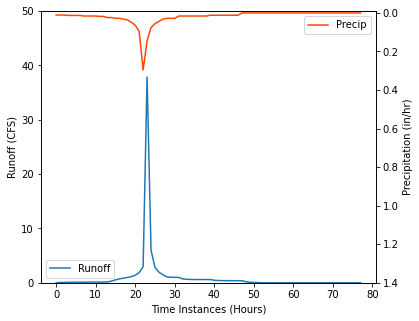

In [60]:
fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73081['Runoff (CFS)']); plt.ylim((-0.001,50)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73081['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72671

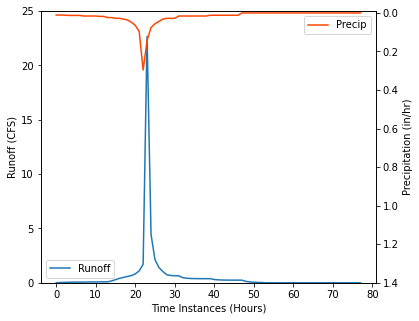

In [61]:
# This is for your Subcatchment 72671
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72671 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5829, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72671.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72671.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72671['Runoff (CFS)']); plt.ylim((-0.001,25)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72671['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72591

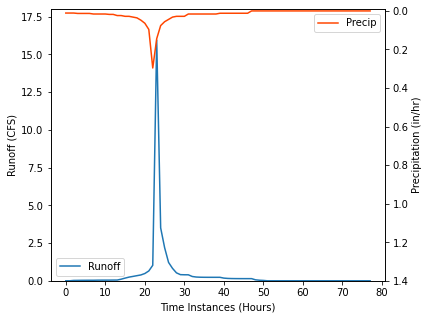

In [62]:
# This is for your Subcatchment 72591
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72591 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5659, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72591.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72591.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72591['Runoff (CFS)']); plt.ylim((-0.001,18)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72591['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72631

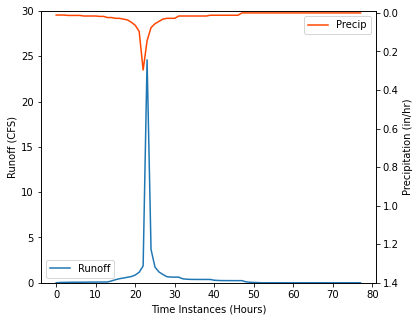

In [63]:
# This is for your Subcatchment 72631
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72631 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5744, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72631.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72631.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72631['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72631['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72781

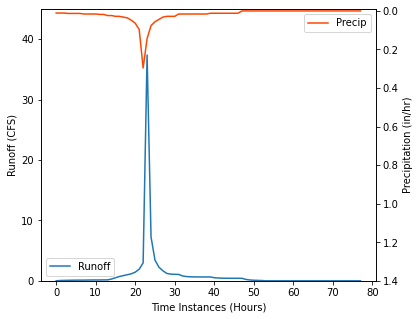

In [64]:
# This is for your Subcatchment 72781
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72781 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5999, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72781.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72781.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72781['Runoff (CFS)']); plt.ylim((-0.001,45)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72781['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72731

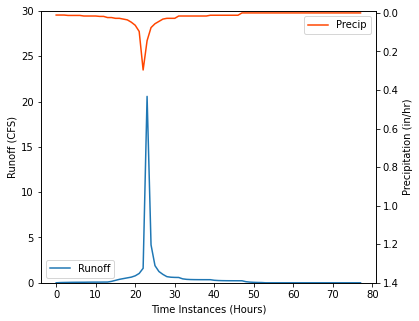

In [65]:
# This is for your Subcatchment 72731
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72731 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 5914, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72731.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72731.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72731['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72731['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 72951

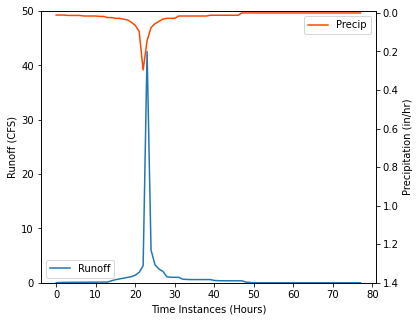

In [66]:
# This is for your Subcatchment 72951
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_72951 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6169, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_72951.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_72951.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_72951['Runoff (CFS)']); plt.ylim((-0.001,50)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_72951['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');


## Subcatchment 73211

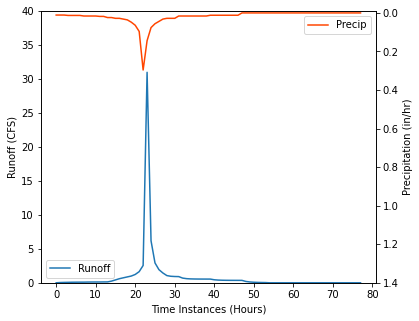

In [67]:
# This is for your Subcatchment 73211
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73211 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6764, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73211.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73211.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73211['Runoff (CFS)']); plt.ylim((-0.001,40)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73211['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73181

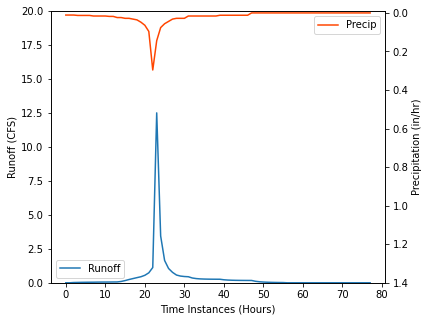

In [68]:
# This is for your Subcatchment 73181
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73181 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6594, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73181.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73181.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73181['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73181['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73171

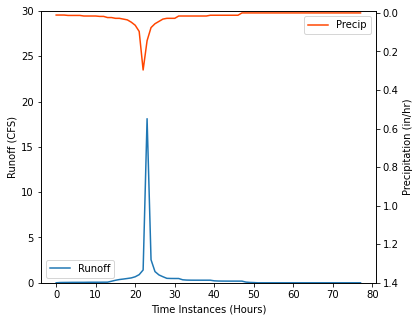

In [69]:
# This is for your Subcatchment 73171
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73171 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6509, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73171.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73171.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73171['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73171['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73121

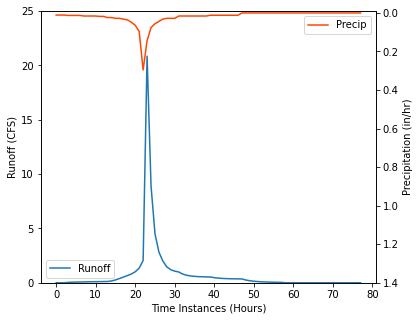

In [70]:
# This is for your Subcatchment 73121
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73121 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6424, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73121.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73121.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73121['Runoff (CFS)']); plt.ylim((-0.001,25)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73121['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73201

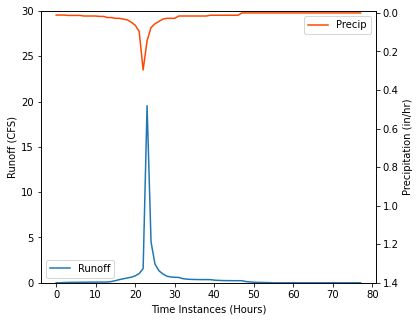

In [71]:
# This is for your Subcatchment 73201
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73201 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6679, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73201.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73201.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73201['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73201['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73301

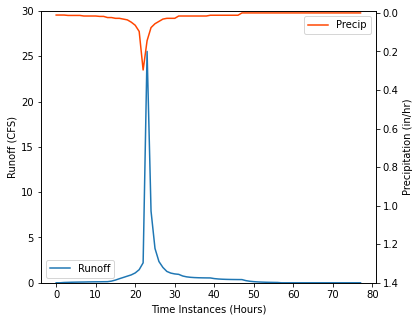

In [72]:
## This is for your Subcatchment 73301
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73301 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 6934, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73301.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73301.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73301['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73301['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73321

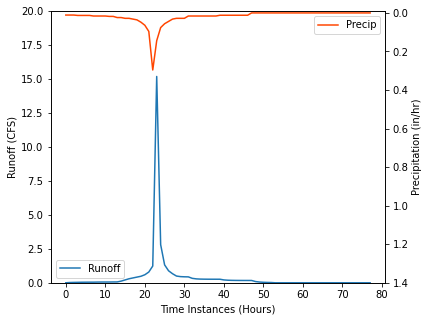

In [73]:
# This is for your Subcatchment 73321
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73321 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7019, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73321.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73321.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73321['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73321['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73391

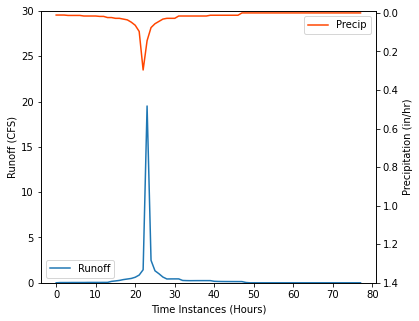

In [74]:
# This is for your Subcatchment 73391
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73391 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7189, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73391.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73391.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73391['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73391['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73551

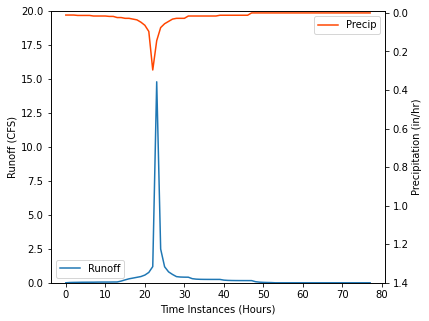

In [75]:
# This is for your Subcatchment 73551
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73551 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7699, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73551.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73551.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73551['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73551['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73421

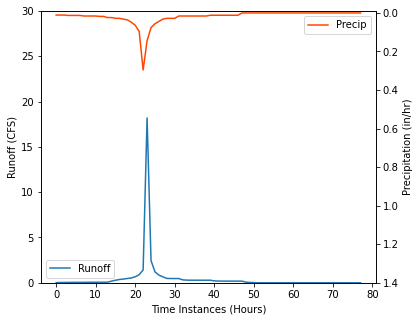

In [76]:
# This is for your Subcatchment 73421
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73421 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7359, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73421.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73421.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73421['Runoff (CFS)']); plt.ylim((-0.001,30)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73421['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73531

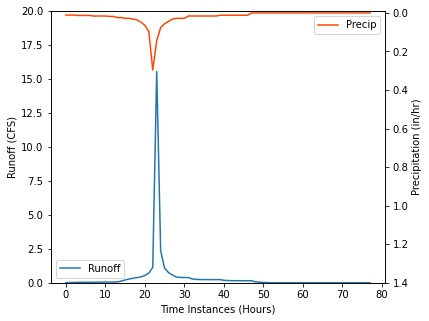

In [77]:
# This is for your Subcatchment 73531
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73531 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7614, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73531.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73531.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73531['Runoff (CFS)']); plt.ylim((-0.001,20)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73531['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

In [78]:
rpt_73531.max()

Date                        01/02/2000 15:00:00
Precip (in/hr)                            0.296
Losses (in/hr)                             0.01
Runoff (CFS)                            15.5478
Total Nitrogen (mg/L)                     1.154
Total Phosphorous (mg/L)                  0.299
dtype: object

## Subcatchment 73571

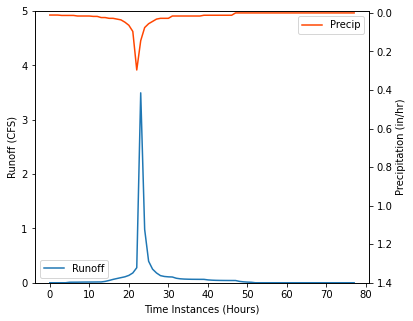

In [79]:
# This is for your Subcatchment 73571
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73571 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7784, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73571.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73571.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)

fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73571['Runoff (CFS)']); plt.ylim((-0.001,5)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73571['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');

## Subcatchment 73461

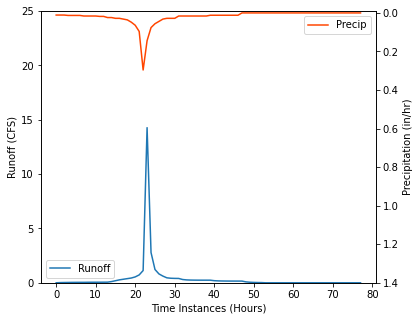

In [80]:
# This is for your Subcatchment 73461
reportColumns = [str(i) for i in np.arange(0,7)]
rpt_73461 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 7444, nrows = 78, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_73461.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_73461.rename(columns = {'0':'Date','2':'Precip (in/hr)','3':'Losses (in/hr)','4':'Runoff (CFS)','5':'Total Nitrogen (mg/L)','6':'Total Phosphorous (mg/L)'},inplace = True)


fig,ax1 = plt.subplots(figsize=(6,5))
line1 = ax1.plot(rpt_73461['Runoff (CFS)']); plt.ylim((-0.001,25)); plt.xlabel('Time Instances (Hours)'); plt.ylabel('Runoff (CFS)');
ax1.legend(['Runoff'],loc='lower left'); ax2 = ax1.twinx(); line2 = ax2.plot(rpt_73461['Precip (in/hr)'],color='orangered');
plt.ylim((-0.01,1.4)); plt.ylabel('Precipitation (in/hr)'); plt.gca().invert_yaxis(); ax2.grid(False); ax2.legend(['Precip'],loc='upper right');


In [81]:
rpt_73461

,Date,Precip (in/hr),Losses (in/hr),Runoff (CFS),Total Nitrogen (mg/L),Total Phosphorous (mg/L)
0,01/01/2000 00:30:00,0.011,0.0,0.0000,0.000,0.000
1,01/01/2000 01:00:00,0.011,0.0,0.0172,0.922,0.238
2,01/01/2000 01:30:00,0.011,0.0,0.0251,1.014,0.262
3,01/01/2000 02:00:00,0.013,0.0,0.0301,1.053,0.272
4,01/01/2000 02:30:00,0.013,0.0,0.0360,1.057,0.273
...,...,...,...,...,...,...
73,01/02/2000 13:00:00,0.000,0.0,0.0000,0.000,0.000
74,01/02/2000 13:30:00,0.000,0.0,0.0000,0.000,0.000
75,01/02/2000 14:00:00,0.000,0.0,0.0000,0.000,0.000
76,01/02/2000 14:30:00,0.000,0.0,0.0000,0.000,0.000


# Outflow near MC7 (In stream, near outlet of SWMM Model)


### No LID Scenario for Comparison
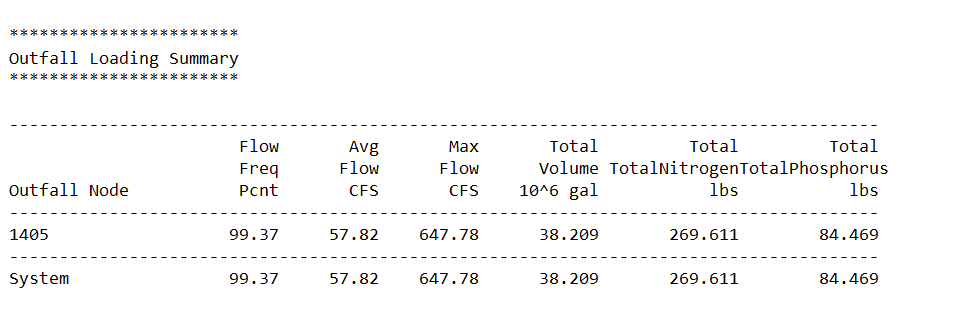

In [82]:
# Outfall
reportColumns = [str(i) for i in np.arange(0,15)]
rpt_1405 = pd.read_csv(r'C:\Users\R. Seth Herbst\Desktop\SWMM Programs and Files\SWMMIO_Altered_INPUTS\Meadow_Creek_Hydrology_Model_UpdatedMar2021_Adjusted_SB_Parameters.txt', skiprows = 37646, nrows = 1, sep="   |    ", names = reportColumns, header = None, engine = 'python')
rpt_1405.dropna(axis = 1, inplace = True); # This might be redundant
# Check df.head before renaming the columns
rpt_1405.rename(columns = {'0':'Outfall Node','6':'Flow Freq %','7':'Avg Flow (CFS)','8':'Max Flow (CFS)','10':'Total Volume (10^6 Gallons)','12':'Total Nitrogen Load (lbs)','14':'Total Phosphorous (lbs)'},inplace = True)

In [83]:
rpt_1405.head()

,Outfall Node,Flow Freq %,Avg Flow (CFS),Max Flow (CFS),Total Volume (10^6 Gallons),Total Nitrogen Load (lbs),Total Phosphorous (lbs)
0,1405,99.37,56.11,625.32,37.112,258.973,81.372
